In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
import math
import utils
import pandas_datareader.data as web

import seaborn as sns
#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

In [12]:
# fetch dataset returns
rx1, ty1, ik1, oe1, du1 = utils.credit_data_reader_returns()
airline_returns = utils.fetch_airline_returns()

appl = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
appl = appl['Close']
appl = utils.get_returns(appl)
appl = appl.reshape(len(appl),1)

#set dataset
dataset = appl

# split dataset into train, test
train, test = utils.split_into_train_test(dataset)

# normalize the dataset
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaler_train.fit(train)
train = scaler_train.transform(train)
test = scaler_train.transform(test)

# reshape into X=t and Y=t+1
look_back = 1
training_input, training_labels = utils.create_dataset(train, look_back)
test_input, test_labels = utils.create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
training_input = np.reshape(training_input, (training_input.shape[0], training_input.shape[1], 1))
test_input = np.reshape(test_input, (test_input.shape[0], test_input.shape[1], 1))

MinMaxScaler()

In [13]:
# Create and fit the LSTM network
nodes = 128
activation_function = 'relu'

# Create input player
features = 1
input_shape = (look_back, features)
inputs = keras.Input(shape=input_shape)

# Add NN layers
x = LSTM(
  nodes, 
  activation=activation_function, 
  return_sequences=False)(inputs)
outputs = Dense(1, activation='relu')(x)

# Create model
model = keras.Model(
  inputs=inputs, 
  outputs=outputs, 
  name='LSTM_model')

# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)

In [14]:
model.fit(training_input, training_labels, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
1339/1339 [==============================] - 2s 860us/step - loss: 0.0175
Epoch 2/20
1339/1339 [==============================] - 1s 765us/step - loss: 0.0065
Epoch 3/20
1339/1339 [==============================] - 1s 762us/step - loss: 0.0062
Epoch 4/20
1339/1339 [==============================] - 1s 761us/step - loss: 0.0061
Epoch 5/20
1339/1339 [==============================] - 1s 763us/step - loss: 0.0061
Epoch 6/20
1339/1339 [==============================] - 1s 767us/step - loss: 0.0061
Epoch 7/20
1339/1339 [==============================] - 1s 759us/step - loss: 0.0060
Epoch 8/20
1339/1339 [==============================] - 1s 760us/step - loss: 0.0060
Epoch 9/20
1339/1339 [==============================] - 1s 761us/step - loss: 0.0060
Epoch 10/20
1339/1339 [==============================] - 1s 759us/step - loss: 0.0061
Epoch 11/20
1339/1339 [==============================] - 1s 768us/step - loss: 0.0061
Epoch 12/20
1339/1339 [==============================] - 1s 755

In [15]:
# model.save('models/model_l2_b_tanh')

42/42 [==============================] - 0s 661us/step


array([0.01828366], dtype=float32)

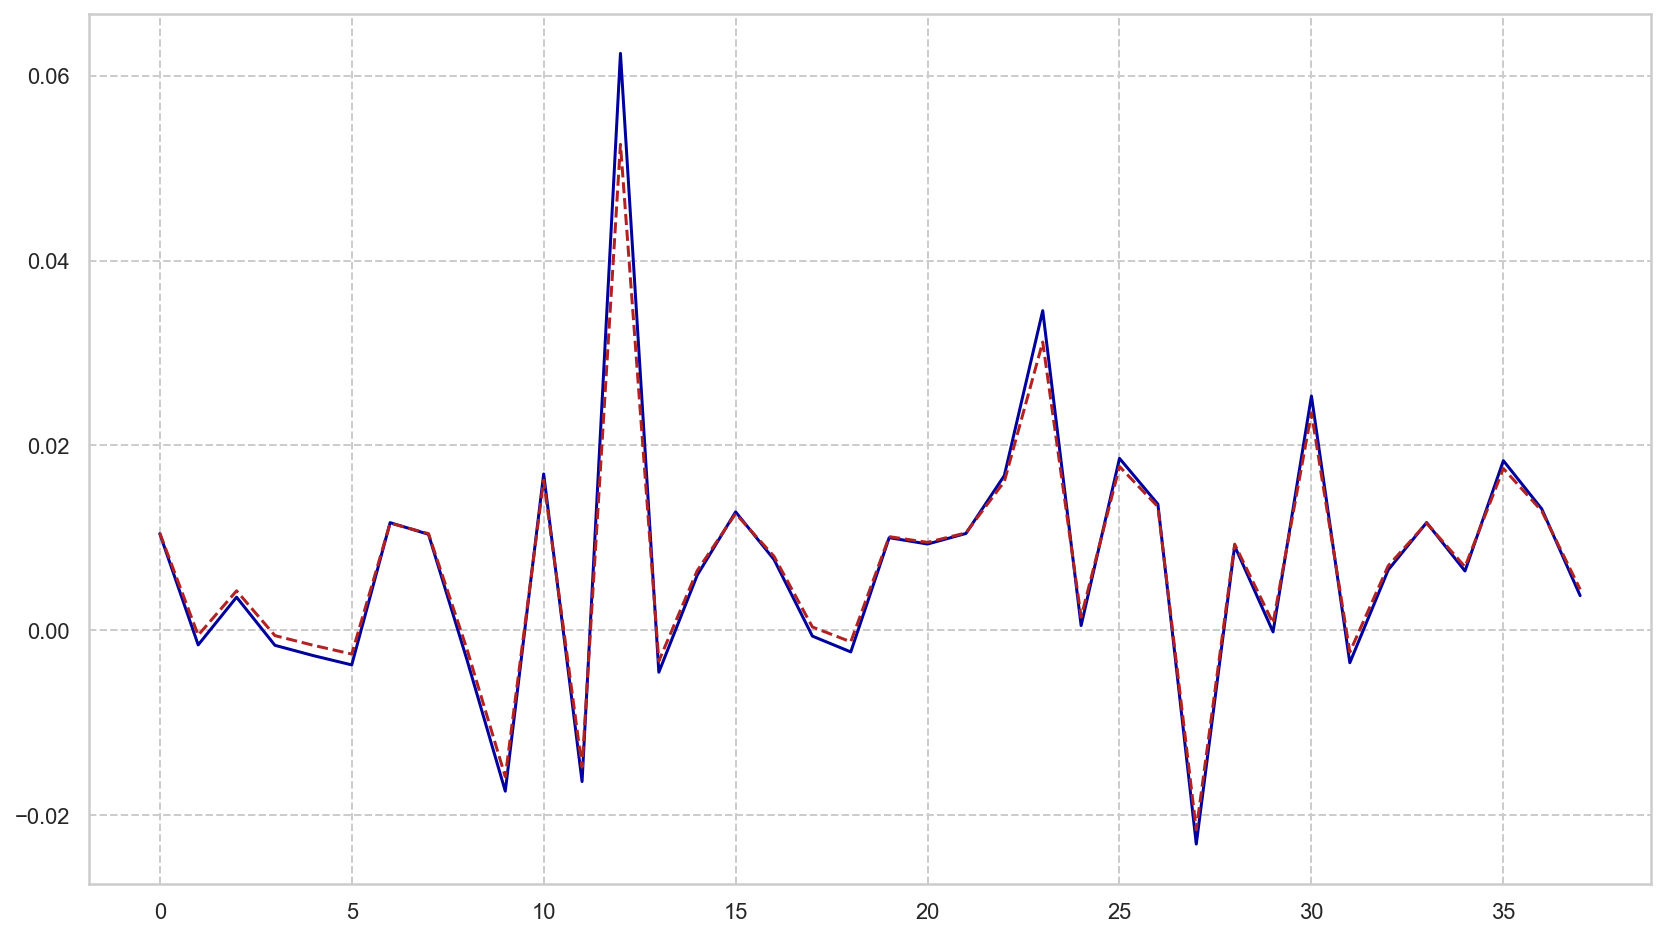

In [16]:
# create fig, axs
fig, axs = plt.subplots(1,1, figsize=(14,8))

# inverse_tranform and plot training_labels
temp = scaler_train.inverse_transform(training_labels.reshape(-1,1))
plt.plot(temp[1:40-look_back])

# calculate predictions
training_pred = model.predict(training_input)

# scale predictions to [0,1] and then inverse_transform back to train scale
scaler_pred = MinMaxScaler(feature_range=(0,1))
training_pred = scaler_pred.fit_transform(training_pred)
training_pred = scaler_train.inverse_transform(training_pred)

# adjust shift in plots so that first entry aligns
diff_first = training_pred[look_back] - temp[0]
diff_first
training_pred = training_pred - diff_first

# plot
plt.plot(training_pred[look_back+1:40], color='firebrick', linestyle='--')

In [17]:
df_length = 30
temp = scaler_train.inverse_transform(training_labels[:df_length-look_back].reshape(-1,1))
df = pd.DataFrame(data=temp, columns=['training_labels'])
df['training_pred'] = training_pred[look_back:df_length]
df['diff'] = df['training_labels'] - df['training_pred']
df

# statistics
true_positives, false_positives, true_negatives, false_negatives, indecisive = 0, 0, 0, 0, 0
for i in range(len(df)):
    local_labels = df['training_labels'][i]
    local_preds = df['training_pred'][i]
    if(local_preds > 0 and local_labels > 0):
        true_positives +=1
    elif(local_preds > 0 and local_labels < 0):
        false_positives +=1
    elif(local_preds < 0 and local_labels < 0):
        true_negatives +=1
    elif(local_preds < 0 and local_labels > 0):
        false_negatives +=1
    else:
        indecisive =+1
        
# true_positives 
# false_positives 
# true_negatives
# false_negatives
# indecisive

# precision = true_positives / (true_positives + false_positives)
# recall = true_positives / (true_positives + false_negatives)
# precision # of the positive predictions, how many are correct?
# recall # how many of the positives did we recall?

,training_labels,training_pred,diff
0,0.011102,0.011102,-9.313226e-10
1,0.010454,0.010521,-6.711949e-05
2,-0.001586,-0.000538,-1.048513e-03
3,0.003580,0.004270,-6.891640e-04
4,-0.001630,-0.000579,-1.050917e-03
5,-0.002745,-0.001629,-1.116288e-03
6,-0.003750,-0.002578,-1.171422e-03
7,0.011648,0.011591,5.742349e-05
8,0.010384,0.010458,-7.434282e-05
9,-0.003169,-0.002030,-1.139534e-03


21/21 [==============================] - 0s 709us/step


array([0.01872], dtype=float32)

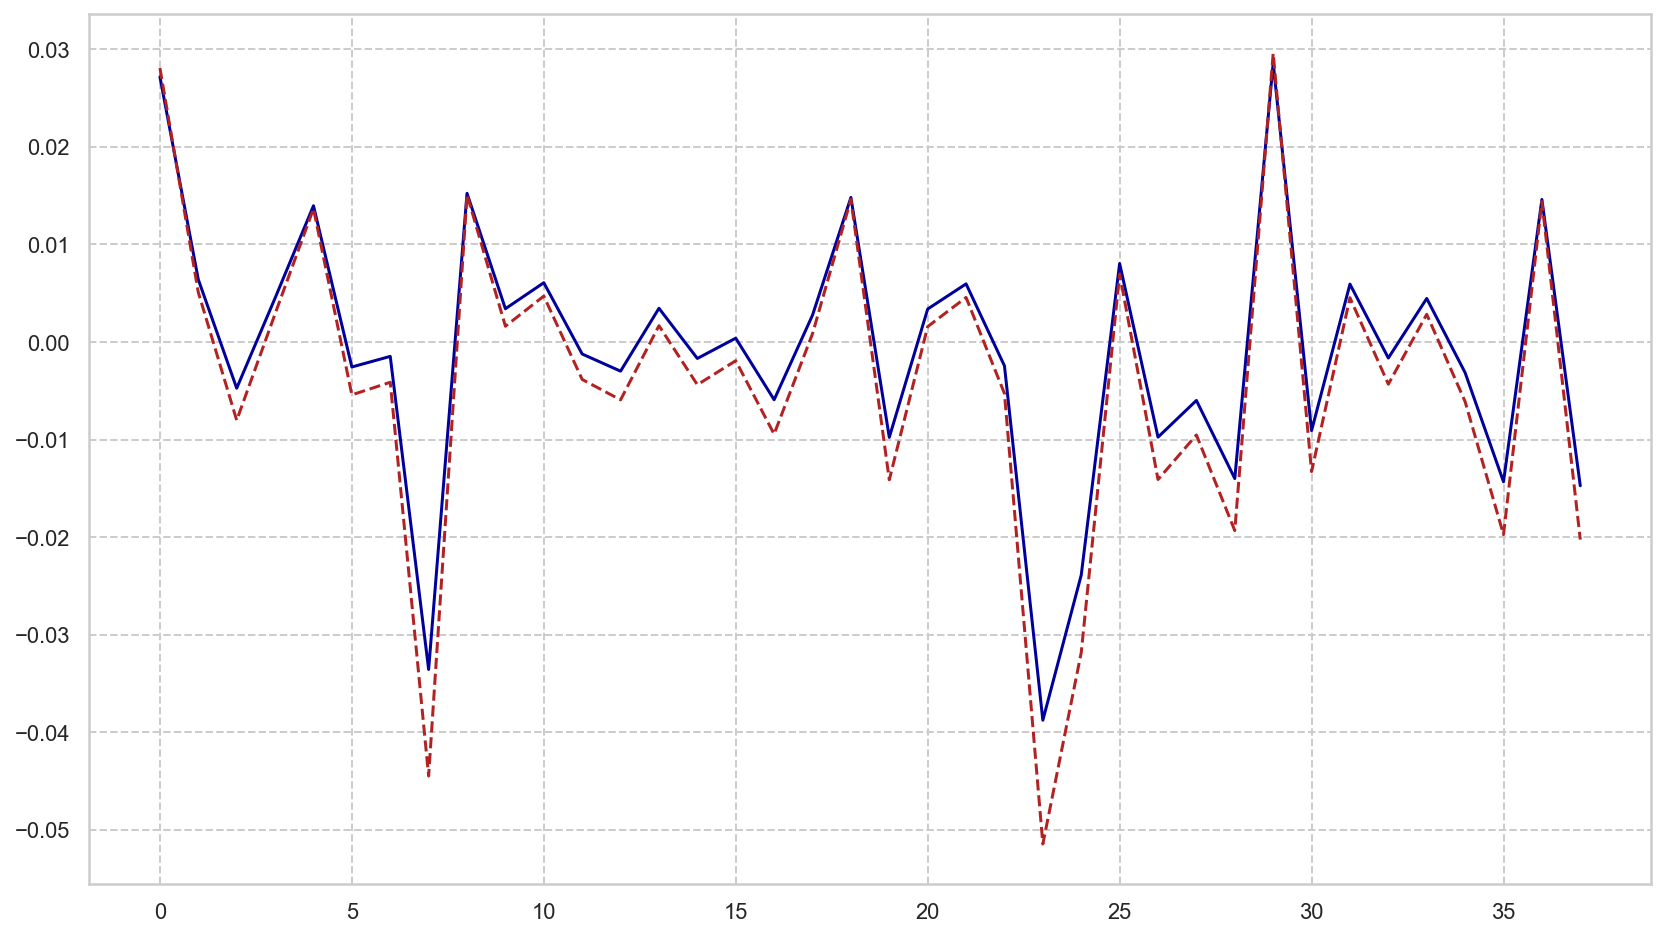

In [18]:
# create fig, axs
fig, axs = plt.subplots(1,1, figsize=(14,8))

# inverse_tranform and plot training_labels
temp = scaler_train.inverse_transform(test_labels.reshape(-1,1))
plt.plot(temp[1:40-look_back])

# calculate predictions
test_pred = model.predict(test_input)

# scale predictions to [0,1] and then inverse_transform back to train scale
scaler_pred = MinMaxScaler(feature_range=(0,1))
test_pred = scaler_pred.fit_transform(test_pred)
test_pred = scaler_train.inverse_transform(test_pred)

# adjust shift in plots so that first entry aligns
diff_first = test_pred[look_back] - temp[0]
diff_first
test_pred = test_pred - diff_first

# plot
plt.plot(test_pred[look_back+1:40], color='firebrick', linestyle='--')

In [19]:
# create dataframe with labels, preds and diff
periods = len(test_labels)
temp = scaler_train.inverse_transform(test_labels[:periods-look_back].reshape(-1,1))
df = pd.DataFrame(data=temp, columns=['test_labels'])
df['test_pred'] = test_pred[look_back:periods]
df['diff'] = df['test_labels'] - df['test_pred']

# add column with long/short
df['position'] = df['test_pred'].apply(lambda x: 'short' if x < 0 else 'long')

# add size column
df.insert(4, "size_percentage", "undefined")
for i in range(len(df)):
    test_pred = df['test_pred']
    size_percentage = 0.3
    df['size_percentage'][i] = size_percentage
df

# statistics
true_positives, false_positives, true_negatives, false_negatives, indecisive = 0, 0, 0, 0, 0
for i in range(len(df)):
    local_labels = temp1 = df['test_labels'][i]
    local_preds = df['test_pred'][i]
    if(local_preds > 0 and local_labels > 0):
        true_positives +=1
    elif(local_preds > 0 and local_labels < 0):
        false_positives +=1
    elif(local_preds < 0 and local_labels < 0):
        true_negatives +=1
    elif(local_preds < 0 and local_labels > 0):
        false_negatives +=1
    else:
        indecisive =+1
        
true_positives 
false_positives 
true_negatives
false_negatives
indecisive

# precision = true_positives / (true_positives + false_positives)
# recall = true_positives / (true_positives + false_negatives)
# precision # of the positive predictions, how many are correct?
# recall # how many of the positives did we recall?

/var/folders/vn/dlt8xpl50tb76_5r7m5gg4vc0000gn/T/ipykernel_40309/4246572040.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['size_percentage'][i] = size_percentage


,test_labels,test_pred,diff,position,size_percentage
0,0.016584,0.016584,0.000000,long,0.3
1,0.027188,0.028085,-0.000897,long,0.3
2,0.006405,0.005085,0.001320,long,0.3
3,-0.004741,-0.008026,0.003285,short,0.3
4,0.004502,0.002885,0.001617,long,0.3
...,...,...,...,...,...
653,-0.014000,-0.019334,0.005334,short,0.3
654,0.005844,0.004438,0.001406,long,0.3
655,0.008529,0.007522,0.001008,long,0.3
656,0.002548,0.000610,0.001938,long,0.3


318

0

301

38

1

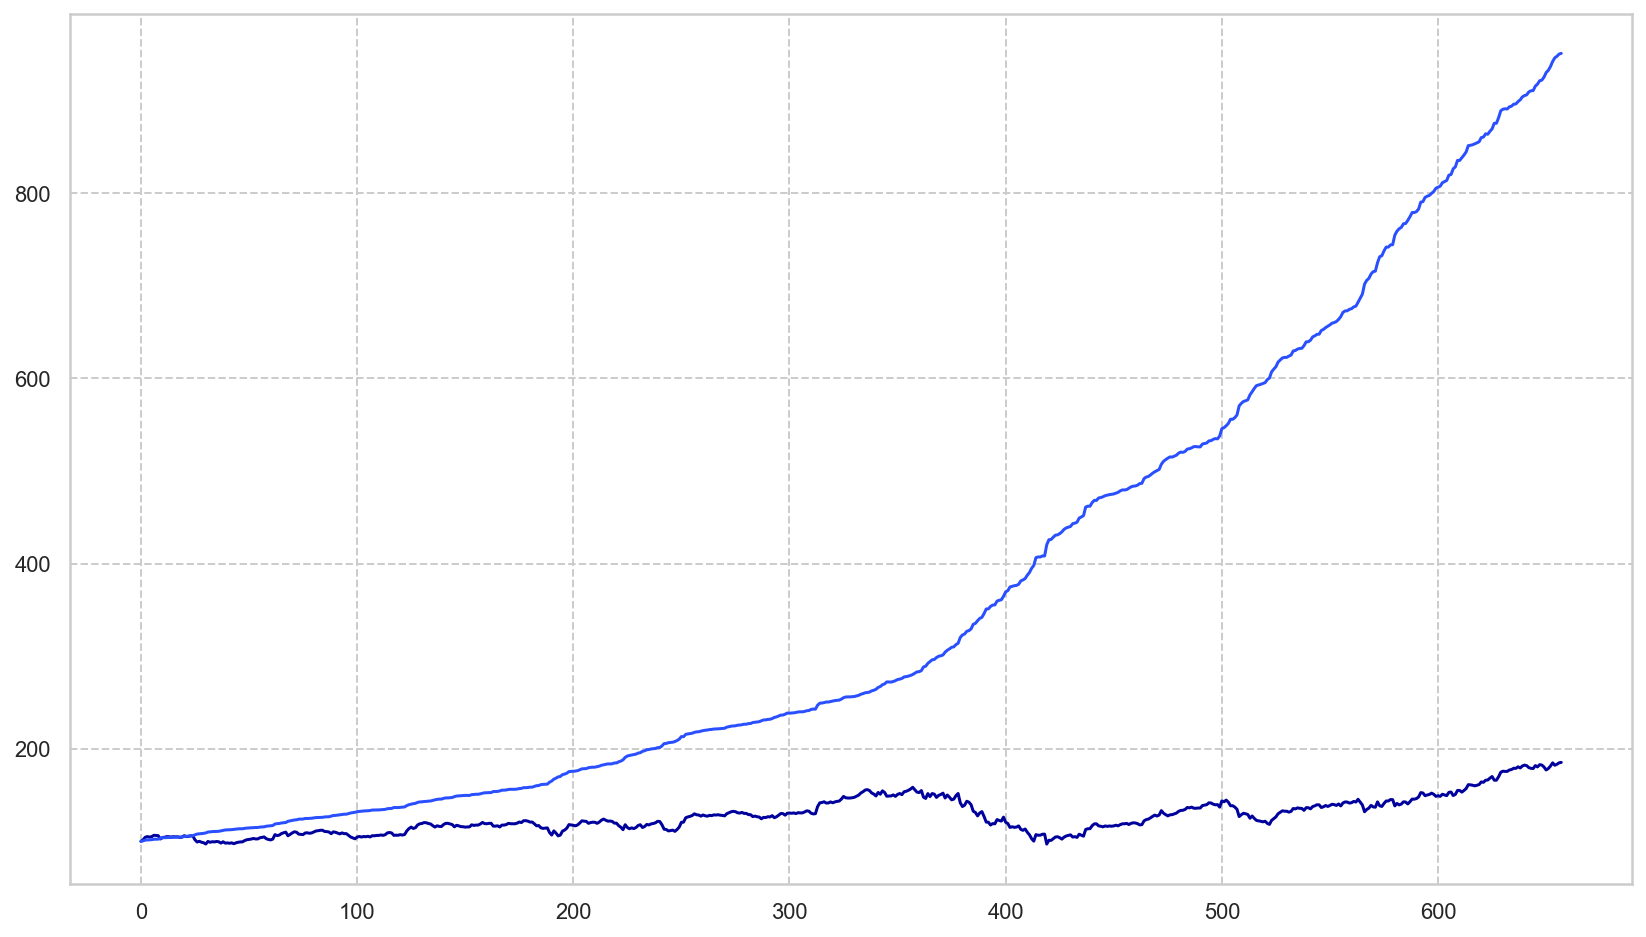

In [20]:
# calculate portfolio value over time (no trading)
cash = 100
portfolio_value_hold = np.ones(periods-1)
for i in range(len(df[:periods])):
    portfolio_value_hold[i] = cash
    size = df['size_percentage'][i]
    r = df['test_labels'][i]
    cash = cash * (1+r)

# calculate portfolio value over time (with trading)
cash = 100
portfolio_value_trading = np.ones(periods-1)
for i in range(len(df[:periods])):
    portfolio_value_trading[i] = cash
    position = df['position'][i]
    size = df['size_percentage'][i]
    r = df['test_labels'][i]
    if(position == 'long'):
        cash = cash * (1+r*size)
    else:
        cash = cash * (1-r*size)

# plot portfolios
fig, axs = plt.subplots(1,1, figsize=(14,8))
plt.plot(portfolio_value_hold[:])
plt.plot(portfolio_value_trading[:])
